--- France Game Score Summary ---
                             Label   Mean   N  CI_95_low  CI_95_high
0         Qwen3-235B-A22B-Instruct  42.35  20  39.805275   44.894725
10                              o3  41.25  20  38.194083   44.305917
6                          kimi-k2  40.60  20  36.940351   44.259649
4   gemini-2.5-flash-preview-05-20  39.45  20  36.735354   42.164646
11                         o4-mini  39.15  20  36.504000   41.796000
8                 llama-4-maverick  39.00  20  36.217221   41.782779
2                command-a-03-2025  32.75  20  31.487158   34.012842
3           devstral-small-1.1-24b  32.30  20  31.216155   33.383845
5                     gpt-4.1-nano  32.30  20  31.225523   33.374477
9   mistral-small-3.2-24b-instruct  31.10  20  30.027406   32.172594
7           llama-3.3-70b-instruct  24.85  20  23.310137   26.389863
1    Qwen3-235B-A22B-Instruct-2507  23.65  20  22.284092   25.015908
---------------------------------


/tmp/ipykernel_1703/4209919605.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


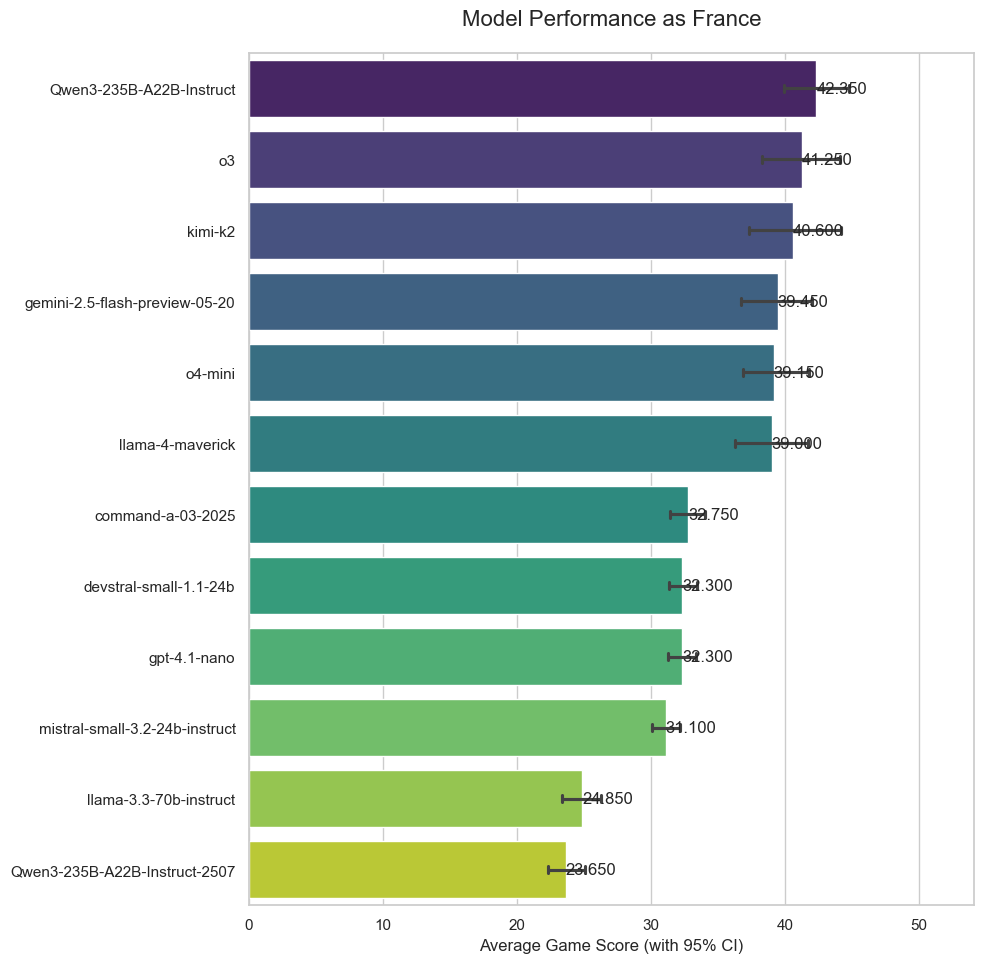

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# EDIT THE LIST BELOW: absolute or relative paths to your experiment folders
# Each folder should contain analysis/statistical_game_analysis/individual/*
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "kimi-k2",
    "../data/sam-exp081-bench": "mistral-small-3.2-24b-instruct",
    "../data/sam-exp082-bench": "devstral-small-1.1-24b",
    "../data/sam-exp083-bench": "gemini-2.5-flash-preview-05-20",
    "../data/sam-exp089-bench":"command-a-03-2025",
    "../data/sam-exp090-bench": "Qwen3-235B-A22B-Instruct",
    "../data/sam-exp091-bench": "llama-4-maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "llama-3.3-70b-instruct",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B-Instruct-2507",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
    "../sam-exp114-bench": "o3-nopress",
    "../sam-exp115-bench": "kimi-k2-nopress",
}

# ---------------------------------------------------------------------------
# Collect all individual France game_score values into a long-form DataFrame
# This format is ideal for Seaborn.
# ---------------------------------------------------------------------------
records = []
for exp_dir, label in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"
    
    if not csv_dir.exists():
        print(f"warning: directory not found, skipping: {csv_dir}")
        continue
        
    csv_files = sorted(csv_dir.glob("run_*_game_analysis.csv"))
    
    num_scores_found = 0
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            france_rows = df[df["power_name"] == "FRANCE"]
            if not france_rows.empty and "game_score" in france_rows.columns:
                score = float(france_rows.iloc[0]["game_score"])
                records.append({"Label": label, "Score": score})
                num_scores_found += 1
        except Exception as exc:
            print(f"warning: could not process {csv_file} – {exc}")
            
    if num_scores_found == 0:
        print(f"no France scores found for {label} in {exp_path}")

# ---------------------------------------------------------------------------
# Build the main DataFrame from the collected records
# ---------------------------------------------------------------------------
if not records:
    raise RuntimeError("No data collected – check the paths and directory structure.")

all_scores_df = pd.DataFrame(records)

# ---------------------------------------------------------------------------
# Optional: Create a summary table for display, similar to the original
# We can do this easily from the long-form DataFrame.
# ---------------------------------------------------------------------------
# The `sem` function for standard error of the mean
def sem(x):
    return np.std(x, ddof=1) / np.sqrt(np.size(x))

summary_df = all_scores_df.groupby('Label')['Score'].agg(['mean', sem, 'count']).reset_index()
summary_df = summary_df.rename(columns={'mean': 'Mean', 'sem': 'SEM', 'count': 'N'})
# Calculate 95% CI from the aggregated data
summary_df['CI_95_low'] = summary_df['Mean'] - 1.96 * summary_df['SEM']
summary_df['CI_95_high'] = summary_df['Mean'] + 1.96 * summary_df['SEM']

print("--- France Game Score Summary ---")
print(summary_df[['Label', 'Mean', 'N', 'CI_95_low', 'CI_95_high']].sort_values('Mean', ascending=False))
print("-" * 33)

# ---------------------------------------------------------------------------
# Plot horizontal bar chart with Seaborn for a nicer look
# ---------------------------------------------------------------------------
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Determine the order of bars by sorting the labels based on their mean score
order = all_scores_df.groupby('Label')['Score'].mean().sort_values(ascending=False).index

# Create the figure and axes
plt.figure(figsize=(10, max(3, 0.7 * len(exp_dirs))))

# Create the bar plot
# Seaborn automatically calculates the mean (for bar length) and 95% CI (for error bars)
ax = sns.barplot(
    data=all_scores_df,
    x="Score",
    y="Label",
    order=order,  # Use the sorted order
    palette="viridis", # A nice color palette
    errorbar=("ci", 95), # Explicitly request 95% CI
    capsize=0.1, # Add caps to the error bars
)

# Improve the plot's labels and title
ax.set_title("Model Performance as France", fontsize=16, pad=20)
ax.set_xlabel("Average Game Score (with 95% CI)", fontsize=12)
ax.set_ylabel("") # The labels on the y-axis are self-explanatory

# Add the mean value as a label on each bar for clarity
for i, bar in enumerate(ax.patches):
    # Get the mean value from our summary dataframe
    label = ax.get_yticklabels()[i].get_text()
    mean_val = summary_df.loc[summary_df['Label'] == label, 'Mean'].iloc[0]
    
    # Position the text
    ax.text(
        bar.get_width() + 0.01, # Position text slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2, # Center vertically on the bar
        f'{mean_val:.3f}', # Format the number
        va='center', 
        ha='left'
    )

# Adjust x-axis limits to make space for the text labels
plt.xlim(right=plt.xlim()[1] * 1.15)

plt.tight_layout()
plt.show()

--- France Game Score Summary (sorted by Mean) ---
                                 mean  median  count
Label                                               
o3                              41.25    41.5     20
kimi-k2                         40.60    36.0     20
gemini-2.5-flash-preview-05-20  39.45    40.5     20
o4-mini                         39.15    39.0     20
o3-nopress                      34.90    35.0     20
command-a-03-2025               32.75    32.5     20
devstral-small-1.1-24b          32.30    31.5     20
kimi-k2-nopress                 31.80    32.5     20
mistral-small-3.2-24b-instruct  31.10    31.0     20
Qwen3-235B-A22B-Instruct        26.20    26.0     20
llama-4-maverick                24.90    24.0     20
llama-3.3-70b-instruct          24.85    24.0     20
Qwen3-235B-A22B-Instruct-2507   23.65    22.0     20
gpt-4.1-nano                    21.55    21.0     20
--------------------------------------------------


/tmp/ipykernel_1703/1132184167.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(scores_by_label, labels=sorted_labels)


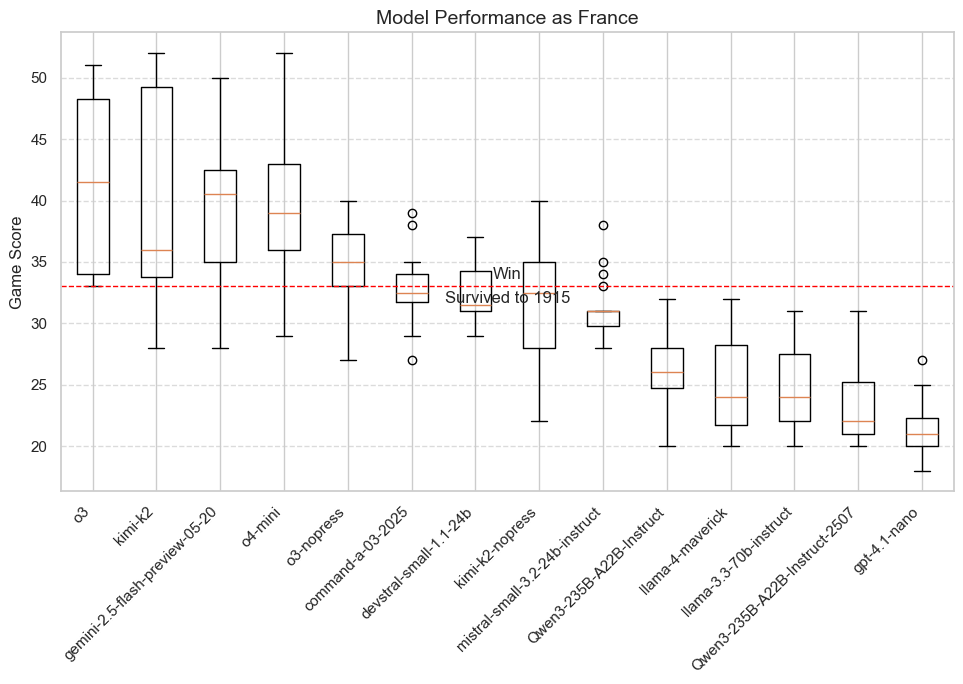

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# EDIT THE LIST BELOW: absolute or relative paths to your experiment folders
# Each folder should contain analysis/statistical_game_analysis/individual/*
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "kimi-k2",
    "../data/sam-exp081-bench": "mistral-small-3.2-24b-instruct",
    "../data/sam-exp082-bench": "devstral-small-1.1-24b",
    "../data/sam-exp083-bench": "gemini-2.5-flash-preview-05-20",
    "../data/sam-exp089-bench":"command-a-03-2025",
    "../data/sam-exp090-bench": "Qwen3-235B-A22B-Instruct",
    "../data/sam-exp091-bench": "llama-4-maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "llama-3.3-70b-instruct",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B-Instruct-2507",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
    "../data/sam-exp114-bench": "o3-nopress",
    "../data/sam-exp115-bench": "kimi-k2-nopress",
}

# ---------------------------------------------------------------------------
# Collect all individual France game_score values into a long-form DataFrame
# ---------------------------------------------------------------------------
records = []
for exp_dir, label in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"

    if not csv_dir.exists():
        print(f"warning: directory not found, skipping: {csv_dir}")
        continue

    csv_files = sorted(csv_dir.glob("run_*_game_analysis.csv"))

    num_scores_found = 0
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            france_rows = df[df["power_name"] == "FRANCE"]
            if not france_rows.empty and "game_score" in france_rows.columns:
                score = float(france_rows.iloc[0]["game_score"])
                records.append({"Label": label, "Score": score})
                num_scores_found += 1
        except Exception as exc:
            print(f"warning: could not process {csv_file} – {exc}")

    if num_scores_found == 0:
        print(f"no France scores found for {label} in {exp_path}")

# ---------------------------------------------------------------------------
# Build the main DataFrame and print a summary
# ---------------------------------------------------------------------------
if not records:
    raise RuntimeError("No data collected – check the paths and directory structure.")

all_scores_df = pd.DataFrame(records)

print("--- France Game Score Summary (sorted by Mean) ---")
summary = all_scores_df.groupby('Label')['Score'].agg(['mean', 'median', 'count'])
print(summary.sort_values('mean', ascending=False))
print("-" * 50)


# ---------------------------------------------------------------------------
# Prepare data for Matplotlib boxplot
# ---------------------------------------------------------------------------
# 1. Determine the order of models based on mean score (descending)
#    This makes the chart much easier to read.
sorted_labels = all_scores_df.groupby('Label')['Score'].mean().sort_values(ascending=False).index

# 2. Create a list of score Series, in the desired order.
#    This is the format that plt.boxplot() expects.
scores_by_label = [all_scores_df[all_scores_df['Label'] == label]['Score'] for label in sorted_labels]


# ---------------------------------------------------------------------------
# Plot: Vertical Box Plot using the Template Style
# ---------------------------------------------------------------------------
# Set a dynamic figure size to accommodate the number of models
plt.figure(figsize=(max(8, 0.7 * len(exp_dirs)), 7))
ax = plt.gca()

# Create the box plot
ax.boxplot(scores_by_label, labels=sorted_labels)

# Apply styling from the template
ax.set_title("Model Performance as France", fontsize=14)
ax.set_ylabel("Game Score", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right") # 'ha' aligns the label with the tick

# ---- Add reference line + annotations from the template -------------------
threshold = 33
ax.axhline(threshold, linestyle="--", linewidth=1, color="red")

y_span = ax.get_ylim()[1] - ax.get_ylim()[0]

# Define offsets relative to the y-axis span for consistent appearance
arrow_head_offset = 0.15 * y_span
arrow_tail_offset = 0.05 * y_span
text_offset       = 0.01 * y_span

# The x-position for the annotations should be in the middle of the plot
x_midpoint = (1 + len(sorted_labels)) / 2

# ↑  Win
arrow_tail_top = threshold + arrow_tail_offset
arrow_head_top = threshold + arrow_head_offset
ax.annotate(
    '', xy=(x_midpoint, arrow_head_top),
    xytext=(x_midpoint, arrow_tail_top),
    arrowprops=dict(arrowstyle='->', linewidth=1)
)
ax.text(
    x_midpoint, threshold + text_offset,
    'Win',
    ha='center', va='bottom'
)

# Survived to 1950  ↓
arrow_tail_bottom = threshold - arrow_tail_offset
arrow_head_bottom = threshold - arrow_head_offset
ax.annotate(
    '', xy=(x_midpoint, arrow_head_bottom),
    xytext=(x_midpoint, arrow_tail_bottom),
    arrowprops=dict(arrowstyle='->', linewidth=1)
)
ax.text(
    x_midpoint, threshold - text_offset,
    'Survived to 1925',
    ha='center', va='top'
)
# ---------------------------------------------------------------------------

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

--- France Game Score Summary (sorted by Mean) ---
                                      mean  median  count
Label                                                    
Qwen3-235B-A22B-Instruct             42.35    42.5     20
o3                                   41.25    41.5     20
Kimi-K2                              40.60    36.0     20
gemini-2.5-flash-preview-05-20       39.45    40.5     20
o4-mini                              39.15    39.0     20
Llama-4-Maverick-17B-128E-Instruct   39.00    37.5     20
Llama-3.3-70B-Instruct               38.10    37.0     20
o3 No Press                          34.90    35.0     20
c4ai-command-a-03-2025               32.75    32.5     20
Devstral-Small-2507                  32.30    31.5     20
gpt-4.1-nano                         32.30    33.0     20
Kimi-K2 No Press                     31.80    32.5     20
Mistral-Small-3.2-24B-Instruct-2506  31.10    31.0     20
Qwen3-235B-A22B-Instruct-2507        23.65    22.0     20
---------------------

/tmp/ipykernel_1703/2655535977.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(scores_by_label, labels=sorted_labels, showfliers=False)


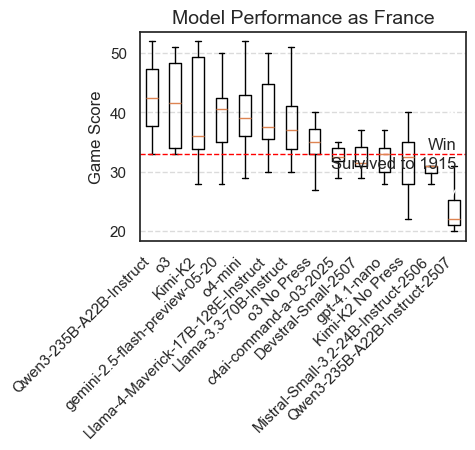

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# EDIT THE LIST BELOW: absolute or relative paths to your experiment folders
# Each folder should contain analysis/statistical_game_analysis/individual/*
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "Kimi-K2",
    "../data/sam-exp081-bench": "Mistral-Small-3.2-24B-Instruct-2506",
    "../data/sam-exp082-bench": "Devstral-Small-2507",
    "../data/sam-exp083-bench": "gemini-2.5-flash-preview-05-20",
    "../data/sam-exp089-bench": "c4ai-command-a-03-2025",
    "../data/sam-exp090-bench": "Qwen3-235B-A22B-Instruct",
    "../data/sam-exp091-bench": "Llama-4-Maverick-17B-128E-Instruct",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "Llama-3.3-70B-Instruct",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B-Instruct-2507",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
    "../data/sam-exp114-bench": "o3 No Press",
    "../data/sam-exp115-bench": "Kimi-K2 No Press",
}

# ---------------------------------------------------------------------------
# Collect all individual France game_score values into a long-form DataFrame
# ---------------------------------------------------------------------------
records = []
for exp_dir, label in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"

    if not csv_dir.exists():
        print(f"warning: directory not found, skipping: {csv_dir}")
        continue

    csv_files = sorted(csv_dir.glob("run_*_game_analysis.csv"))

    num_scores_found = 0
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            france_rows = df[df["power_name"] == "FRANCE"]
            if not france_rows.empty and "game_score" in france_rows.columns:
                score = float(france_rows.iloc[0]["game_score"])
                records.append({"Label": label, "Score": score})
                num_scores_found += 1
        except Exception as exc:
            print(f"warning: could not process {csv_file} – {exc}")

    if num_scores_found == 0:
        print(f"no France scores found for {label} in {exp_path}")

# ---------------------------------------------------------------------------
# Build the main DataFrame and print a summary
# ---------------------------------------------------------------------------
if not records:
    raise RuntimeError("No data collected – check the paths and directory structure.")

all_scores_df = pd.DataFrame(records)

print("--- France Game Score Summary (sorted by Mean) ---")
summary = all_scores_df.groupby('Label')['Score'].agg(['mean', 'median', 'count'])
print(summary.sort_values('mean', ascending=False))
print("-" * 50)

# ---------------------------------------------------------------------------
# Prepare data for Matplotlib boxplot
# ---------------------------------------------------------------------------
sorted_labels = (
    all_scores_df.groupby('Label')['Score']
    .mean()
    .sort_values(ascending=False)
    .index
)
scores_by_label = [
    all_scores_df[all_scores_df['Label'] == label]['Score'] for label in sorted_labels
]

# ---------------------------------------------------------------------------
# Plot: Vertical Box Plot using the Template Style
# ---------------------------------------------------------------------------
plt.figure(
    figsize=(
        max(8, 0.7 * len(exp_dirs)) * 0.5,  # ½ previous width
        7 * 2 / 3                           # ⅔ previous height
    )
)
ax = plt.gca()

ax.boxplot(scores_by_label, labels=sorted_labels, showfliers=False)

ax.set_title("Model Performance as France", fontsize=14)
ax.set_ylabel("Game Score", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.xticks(rotation=45, ha="right")

# ---- Add reference line + annotations positioned at the right edge --------
threshold = 33
ax.axhline(threshold, linestyle="--", linewidth=1, color="red")

y_span = ax.get_ylim()[1] - ax.get_ylim()[0]
arrow_head_offset = 0.15 * y_span
arrow_tail_offset = 0.05 * y_span
text_offset = 0.01 * y_span
x_right_position = len(sorted_labels)  # Position at the rightmost box plot

# ↑  Win
ax.annotate(
    '',
    xy=(x_right_position - 0.1, threshold + arrow_head_offset * 1.5),
    xytext=(x_right_position - 0.1, threshold + arrow_tail_offset * 2),
    arrowprops=dict(arrowstyle='->', linewidth=1),
)
ax.text(x_right_position + 0.1, threshold + text_offset, 'Win', ha='right', va='bottom')

# Survived to 1915  ↓
ax.annotate(
    '',
    xy=(x_right_position - 0.1, threshold - arrow_head_offset * 1.5),
    xytext=(x_right_position - 0.1, threshold - arrow_tail_offset * 2),
    arrowprops=dict(arrowstyle='->', linewidth=1),
)
ax.text(x_right_position + 0.1, threshold - text_offset, 'Survived to 1925', ha='right', va='top')
# ---------------------------------------------------------------------------

plt.tight_layout()
plt.show()

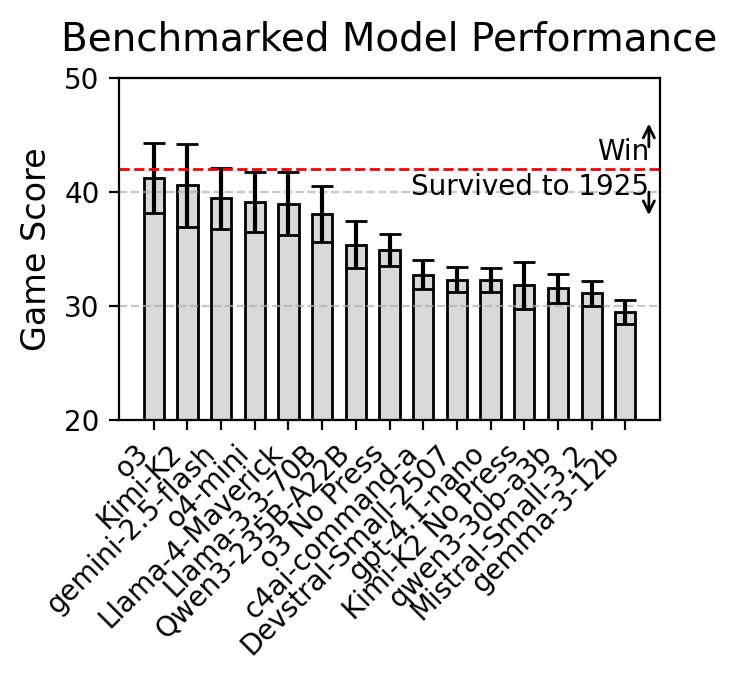

In [2]:
# %%
"""
Bar chart with 95 % CIs.

Changes relative to the previous version ONLY:
  • ylim fixed at 0 → 40.05
  • removed numeric labels above bars
  • bars now have a light‑grey fill (edge still black)
  • everything else (size, DPI, arrows, grid, etc.) unchanged
"""
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1.  Load France game scores → all_scores_df  (identical to earlier)
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "Kimi-K2",
    "../data/sam-exp081-bench": "Mistral-Small-3.2",
    "../data/sam-exp082-bench": "Devstral-Small-2507",
    "../data/sam-exp083-bench": "gemini-2.5-flash",
    "../data/sam-exp089-bench": "c4ai-command-a",
    #"../data/sam-exp090-bench": "Qwen3-235B-A22B",
    "../data/sam-exp091-bench": "Llama-4-Maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "Llama-3.3-70B",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
    "../data/sam-exp114-bench": "o3 No Press",
    "../data/sam-exp115-bench": "Kimi-K2 No Press",    
    "../data/sam-exp118-bench": "gemma-3-12b",
    "../data/sam-exp119-bench": "qwen3-30b-a3b",
    
    
}

records = []
for exp_dir, label in exp_dirs.items():
    csv_dir = (Path(exp_dir).expanduser().resolve()
               / "analysis/statistical_game_analysis/individual")
    if not csv_dir.exists():
        continue

    for csv_file in csv_dir.glob("run_*_game_analysis.csv"):
        try:
            df = pd.read_csv(csv_file)
            fr = df[df["power_name"] == "FRANCE"]
            if not fr.empty and "game_score" in fr.columns:
                records.append({"Label": label,
                                "Score": float(fr.iloc[0]["game_score"])})
        except Exception:
            pass

if not records:
    raise RuntimeError("No data collected – check paths & structure.")

all_scores_df = pd.DataFrame(records)

# ---------------------------------------------------------------------------
# 2.  Summary statistics
# ---------------------------------------------------------------------------
stats = (
    all_scores_df
    .groupby("Label")["Score"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean": "Mean", "std": "Std", "count": "N"})
    .reset_index()
)
stats["SEM"]  = stats["Std"] / np.sqrt(stats["N"])
stats["CI95"] = 1.96 * stats["SEM"]
stats = stats.sort_values("Mean", ascending=False)

# ---------------------------------------------------------------------------
# 3.  Figure (same formula; DPI remains 200)
# ---------------------------------------------------------------------------
fig_w = max(7, 0.4 * len(exp_dirs)) * 0.5
fig_h = 7 * 1/2
plt.figure(figsize=(fig_w, fig_h), dpi=200)
ax = plt.gca()

x = np.arange(len(stats))
bars = ax.bar(
    x, stats["Mean"],
    width=0.6,
    yerr=stats["CI95"],
    capsize=4,
    color="0.85",          # light grey fill
    edgecolor="black",
    linewidth=1.0
)

ax.set_title("Benchmarked Model Performance", fontsize=14, pad=10)
ax.set_ylabel("Game Score", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(stats["Label"], rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

# ---------------------------------------------------------------------------
# 4.  Fixed y‑limits + threshold & annotations
# ---------------------------------------------------------------------------
ax.set_ylim(20, 50.05)          # ← requested ylim

threshold = 42
ax.axhline(threshold, linestyle="--", linewidth=1, color="red")

y_span = ax.get_ylim()[1] - ax.get_ylim()[0]
head_off = 0.15 * y_span
tail_off = 0.05 * y_span
txt_off  = 0.01 * y_span
x_anno   = len(stats) - 0.3

# ↑ Win
ax.annotate('', xy=(x_anno, threshold + head_off),
            xytext=(x_anno, threshold + tail_off),
            arrowprops=dict(arrowstyle='->', linewidth=1))
ax.text(x_anno, threshold + txt_off, 'Win',
        ha='right', va='bottom')

# Survived to 1915 ↓
ax.annotate('', xy=(x_anno, threshold - head_off),
            xytext=(x_anno, threshold - tail_off),
            arrowprops=dict(arrowstyle='->', linewidth=1))
ax.text(x_anno, threshold - txt_off, 'Survived to 1925',
        ha='right', va='top')

plt.tight_layout()
plt.show()
# %%


In [3]:
# %%
"""
Welch’s two-sample t-tests for each score disparity.

Outputs the t-statistic and two-tailed p-value:
  • o3            vs  Kimi-K2
  • o3 No Press   vs  Kimi-K2 No Press
"""
from scipy.stats import ttest_ind

pairs = [
    ("o3", "Kimi-K2"),
    ("o3 No Press", "Kimi-K2 No Press"),
]

for left, right in pairs:
    left_scores  = all_scores_df.loc[all_scores_df["Label"] == left,  "Score"]
    right_scores = all_scores_df.loc[all_scores_df["Label"] == right, "Score"]

    if left_scores.empty or right_scores.empty:
        raise ValueError(f"Missing scores for '{left}' or '{right}'")

    t_stat, p_val = ttest_ind(left_scores, right_scores, equal_var=False)
    delta        = left_scores.mean() - right_scores.mean()

    print(f"{left:<13} – {right:<17}  Δ={delta:+6.2f}   t={t_stat:+7.3f}   p={p_val:.3e}")


o3            – Kimi-K2            Δ= +0.65   t= +0.267   p=7.908e-01
o3 No Press   – Kimi-K2 No Press   Δ= +3.10   t= +2.425   p=2.080e-02


In [ ]:
# %%
"""
Correlate Diplomacy benchmark means (France game scores) with Chatbot-Arena Elo.

• Builds an in-memory DataFrame of the published Arena scores
• Maps our internal labels → Arena model names
• Joins on the overlap and prints Pearson r for:
    – overall Elo
    – hard-query Elo
    – long-query Elo
"""

from io import StringIO
import textwrap

# ────────────────────────────────────────────────────────────────────────────────
# 1.  Chatbot-Arena data  (2025-07 snapshot)
# ────────────────────────────────────────────────────────────────────────────────
arena_csv = textwrap.dedent("""
model,arena_overall,arena_hard,arena_long
o3,1451,1454,1417
kimi-k2,1420,1431,1405
qwen3-235b-a22b (no thinking),1397,1408,1398
gemini-2.5-flash,1409,1413,1419
o4-mini,1396,1405,1371
llama-4-maverick,1330,1334,1335
llama-3.3-070b,1316,1313,1310
command-a-03-2025,1345,1351,1355
gpt-4.1-nano,1319,1325,1322
qwen3-30b-a3b,1329,1344,1341
mistral-small-2506,1349,1356,1351
gemma-3-12b-it,1340,1329,1345
""")
arena_df = pd.read_csv(StringIO(arena_csv))

# ────────────────────────────────────────────────────────────────────────────────
# 2.  Label mapping (bench label → Arena label)
# ────────────────────────────────────────────────────────────────────────────────
label_to_arena = {
    "o3": "o3",
    "Kimi-K2": "kimi-k2",
    "Qwen3-235B-A22B": "qwen3-235b-a22b (no thinking)",
    "gemini-2.5-flash": "gemini-2.5-flash",
    "o4-mini": "o4-mini",
    "Llama-4-Maverick": "llama-4-maverick",
    "Llama-3.3-70B": "llama-3.3-070b",
    "c4ai-command-a": "command-a-03-2025",
    "gpt-4.1-nano": "gpt-4.1-nano",
    "qwen3-30b-a3b": "qwen3-30b-a3b",
    "Mistral-Small-3.2": "mistral-small-2506",
    "gemma-3-12b": "gemma-3-12b-it",
}

# attach mapping → join on common models
stats["arena_model"] = stats["Label"].map(label_to_arena)
merged = stats.merge(arena_df, left_on="arena_model", right_on="model", how="inner")

if merged.empty:
    raise RuntimeError("No overlapping models between Diplomacy benchmark and Arena data – check mapping.")

# ────────────────────────────────────────────────────────────────────────────────
# 3.  Pearson correlations
# ────────────────────────────────────────────────────────────────────────────────
for col in ["arena_overall", "arena_hard", "arena_long"]:
    r = merged["Mean"].corr(merged[col])
    metric = col.split("_", 1)[1]
    print(f"Pearson r  (Diplomacy Mean ⇆ Arena {metric}) :  {r:+.3f}   n={len(merged)}")


# %%
"""
Build a LaTeX table of (our) model ID → Chatbot-Arena overall Elo → mean Diplomacy score.
"""

# ────────────────────────────────────────────────────────────────────────────────
table_df = (
    merged[["Label", "arena_overall", "Mean"]]
    .rename(columns={"Label": "Model", "arena_overall": "ArenaOverall", "Mean": "BenchMean"})
    .sort_values("BenchMean", ascending=False)
    .reset_index(drop=True)
)
table_df["BenchMean"] = table_df["BenchMean"].round(2)

latex_table = table_df.to_latex(index=False, column_format="lrr", float_format="%.0f")
print(latex_table)


Pearson r  (Diplomacy Mean ⇆ Arena overall) :  +0.651   n=12
Pearson r  (Diplomacy Mean ⇆ Arena hard) :  +0.644   n=12
Pearson r  (Diplomacy Mean ⇆ Arena long) :  +0.539   n=12


KeyError: 'Mean'

In [7]:
# %%
"""
LaTeX table: canonical model ID → Chatbot-Arena overall Elo → Diplomacy game score
(mean ± 95 % CI, one decimal).  Rows sorted by mean game score.

Fix: sort before dropping auxiliary columns so “Mean” is still present during sort.
"""

# ────────────────────────────────────────────────────────────────────────────────
# 1.  Sort by benchmark mean, then format ± CI95
# ────────────────────────────────────────────────────────────────────────────────
sorted_df = merged.sort_values("Mean", ascending=False).copy()

sorted_df["Diplomacy Game Score"] = sorted_df.apply(
    lambda r: f"{r['Mean']:.1f} ± {r['CI95']:.1f}", axis=1
)

table_df = (
    sorted_df[["Label", "arena_overall", "Diplomacy Game Score"]]
    .rename(columns={"Label": "Model", "arena_overall": "Arena Overall"})
    .reset_index(drop=True)
)

latex_table = table_df.to_latex(
    index=False,
    column_format="lrl",
    escape=False  # keep the “±” symbol
)

print(latex_table)


\begin{tabular}{lrl}
\toprule
Model & Arena Overall & Diplomacy Game Score \\
\midrule
o3 & 1451 & 41.2 ± 3.1 \\
Kimi-K2 & 1420 & 40.6 ± 3.7 \\
gemini-2.5-flash & 1409 & 39.5 ± 2.7 \\
o4-mini & 1396 & 39.1 ± 2.6 \\
Llama-4-Maverick & 1330 & 39.0 ± 2.8 \\
Llama-3.3-70B & 1316 & 38.1 ± 2.5 \\
Qwen3-235B-A22B & 1397 & 35.4 ± 2.1 \\
c4ai-command-a & 1345 & 32.8 ± 1.3 \\
gpt-4.1-nano & 1319 & 32.3 ± 1.1 \\
qwen3-30b-a3b & 1329 & 31.6 ± 1.3 \\
Mistral-Small-3.2 & 1349 & 31.1 ± 1.1 \\
gemma-3-12b & 1340 & 29.4 ± 1.0 \\
\bottomrule
\end{tabular}



--- Relationship‑Perception Error (per game) ---
                  model      Mean   N      CI95
10                   o3 -1.014643  20  0.150473
1               Kimi-K2 -0.621992  20  0.107580
6     Qwen3-235B-A22B-2 -0.522384  20  0.145026
11              o4-mini -0.520034  20  0.120289
5       Qwen3-235B-A22B -0.356464  20  0.194125
8      gemini-2.5-flash -0.246503  20  0.103871
0   Devstral-Small-2507 -0.141038  20  0.154086
4     Mistral-Small-3.2 -0.083490  20  0.122267
3      Llama-4-Maverick -0.020554  20  0.101359
2         Llama-3.3-70B  0.119772  20  0.154622
9          gpt-4.1-nano  0.137841  20  0.154038
7        c4ai-command-a  0.185353  20  0.124374
-----------------------------------------------


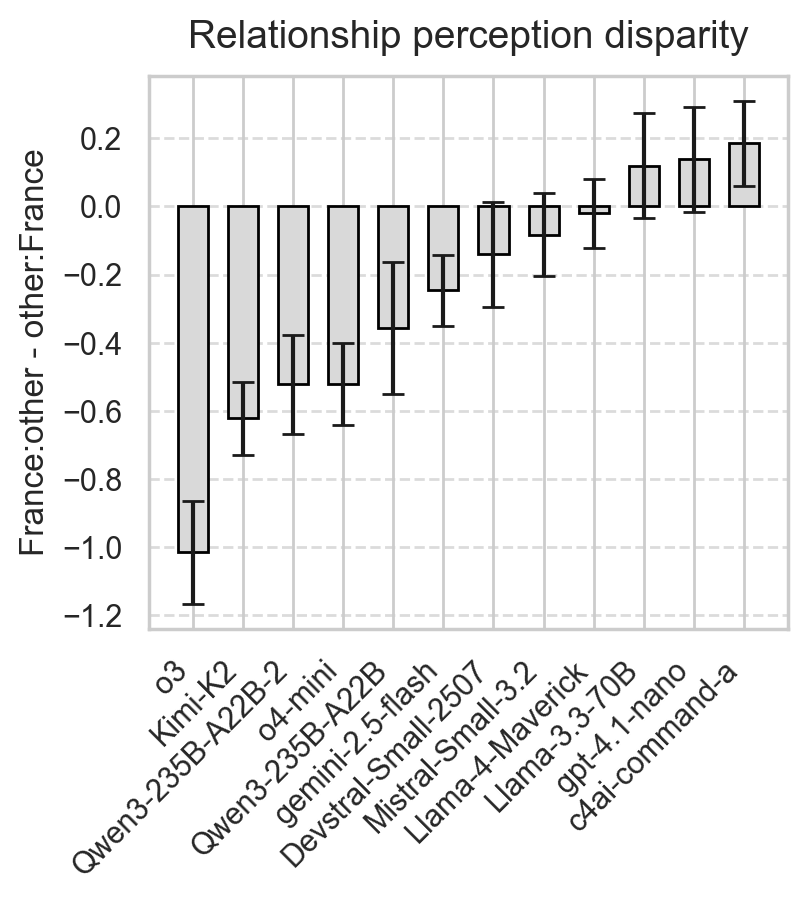

In [5]:
# %%
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Map label → benchmark directory  (EDIT AS NEEDED)
# ---------------------------------------------------------------------------
exp_dirs = {
    "Kimi-K2":              "../data/sam-exp080-bench",
    "Mistral-Small-3.2":    "../data/sam-exp081-bench",
    "Devstral-Small-2507":  "../data/sam-exp082-bench",
    "gemini-2.5-flash":     "../data/sam-exp083-bench",
    "c4ai-command-a":       "../data/sam-exp089-bench",
    "Qwen3-235B-A22B":      "../data/sam-exp090-bench",
    "Llama-4-Maverick":     "../data/sam-exp091-bench",
    "gpt-4.1-nano":         "../data/sam-exp092-bench",
    "Llama-3.3-70B":        "../data/sam-exp106-bench",
    "Qwen3-235B-A22B-2":    "../data/sam-exp108-bench",  # distinct run folder
    "o3":                   "../data/sam-exp113-bench",
    "o4-mini":              "../data/sam-exp112-bench",
}


# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------
rel_pat = re.compile(r'([A-Z]+):(-?\d+\.?\d*)')

def rel_dict(s: str):
    """'RUSSIA:0|GERMANY:1' → {'RUSSIA':0.0, 'GERMANY':1.0}"""
    if not isinstance(s, str): return {}
    return {p: float(v) for p, v in rel_pat.findall(s)}

# ---------------------------------------------------------------------------
# 1.  Iterate over every phase file and collect phase‑level errors
# ---------------------------------------------------------------------------
phase_errors = []   # rows: model, game_id, phase_error

for label, dir_ in exp_dirs.items():
    csv_dir = (Path(dir_).expanduser().resolve()
               / "analysis/statistical_game_analysis/individual")
    if not csv_dir.exists():
        print(f"skip {label}: dir not found")
        continue

    for csv in csv_dir.glob("run_*_phase_analysis.csv"):
        game_id = f"{label}_{csv.stem}"

        df = pd.read_csv(csv)

        # keep only order_generation rows
        df = df[df["analyzed_response_type"] == "order_generation"]

        # index by power for fast lookups
        df_by_phase = df.groupby("game_phase")

        for phase, ph_df in df_by_phase:
            fr_row = ph_df[ph_df["power_name"] == "FRANCE"]
            if fr_row.empty:           # France eliminated already
                continue
            if fr_row["supply_centers_owned_count"].iloc[0] == 0:
                continue              # eliminate phases post‑elimination

            fr_rel = rel_dict(fr_row["relationships"].iloc[0])

            # build error list across other powers
            errs = []
            for _, row in ph_df.iterrows():
                pow_name = row["power_name"]
                if pow_name == "FRANCE":    # skip self
                    continue
                other_to_fr = rel_dict(row["relationships"]).get("FRANCE")
                fr_to_other = fr_rel.get(pow_name)
                if other_to_fr is None or fr_to_other is None:
                    continue
                errs.append(fr_to_other - other_to_fr)
            if errs:
                phase_errors.append({
                    "model": label,
                    "game_id": game_id,
                    "phase_error": np.mean(errs)
                })

if not phase_errors:
    raise RuntimeError("No usable data found – check directory mapping.")

phase_df = pd.DataFrame(phase_errors)

# ---------------------------------------------------------------------------
# 2.  Per‑game aggregation → one error value per match
# ---------------------------------------------------------------------------
game_err = (
    phase_df
    .groupby(["model", "game_id"])["phase_error"]
    .mean()
    .reset_index(name="game_error")
)

# ---------------------------------------------------------------------------
# 3.  Summary stats for bar chart (mean ± 95 % CI)
# ---------------------------------------------------------------------------
summary = (
    game_err
    .groupby("model")["game_error"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean":"Mean", "std":"Std", "count":"N"})
    .reset_index()
)

summary["SEM"]  = summary["Std"] / np.sqrt(summary["N"])
summary["CI95"] = 1.96 * summary["SEM"]
summary = summary.sort_values("Mean")   # lower error ⇒ better

print("--- Relationship‑Perception Error (per game) ---")
print(summary[["model", "Mean", "N", "CI95"]])
print("-----------------------------------------------")

# ---------------------------------------------------------------------------
# 4.  Bar chart (light grey bars, 95 % CI whiskers, DPI 200)
# ---------------------------------------------------------------------------
fig_w = max(8, 0.7*len(summary)) * 0.5
fig_h = 7 * 2/3
plt.figure(figsize=(fig_w, fig_h), dpi=200)
ax = plt.gca()

x = np.arange(len(summary))
ax.bar(
    x, summary["Mean"],
    width=0.6,
    yerr=summary["CI95"],
    capsize=4,
    color="0.85",
    edgecolor="black",
    linewidth=1.0,
)

ax.set_title("Relationship perception disparity", fontsize=14, pad=10)
ax.set_ylabel("France:other - other:France", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(summary["model"], rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
# %%


--- Relationship‑Perception Error (per game) ---
                  model      Mean   N      CI95
3      Llama-4-Maverick  0.391202  20  0.076001
0   Devstral-Small-2507  0.549214  20  0.072654
9          gpt-4.1-nano  0.673045  20  0.123313
7        c4ai-command-a  0.682438  20  0.086291
6     Qwen3-235B-A22B-2  0.685271  20  0.143192
5       Qwen3-235B-A22B  0.736448  20  0.141611
8      gemini-2.5-flash  0.777771  20  0.085197
4     Mistral-Small-3.2  0.778789  20  0.087606
1               Kimi-K2  0.829580  20  0.091462
11              o4-mini  1.054657  20  0.094752
2         Llama-3.3-70B  1.086544  20  0.100048
10                   o3  1.202454  20  0.120922
-----------------------------------------------


/tmp/ipykernel_1703/939141411.py:146: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/home/sam/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


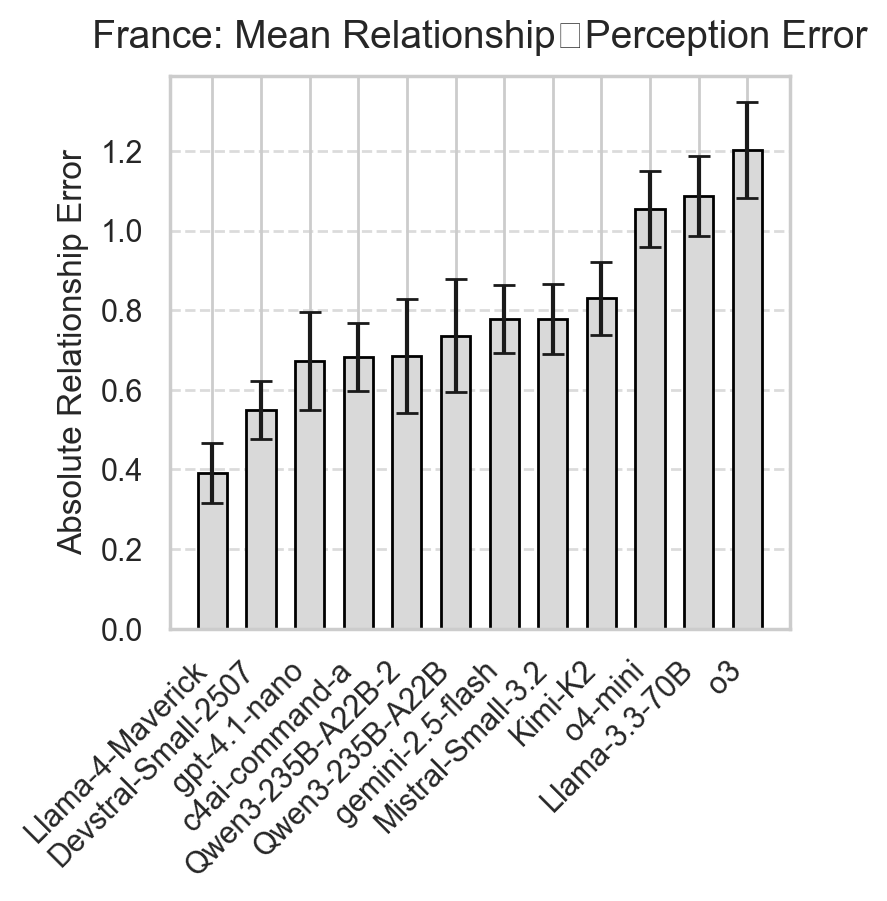

In [6]:
# %%
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Map label → benchmark directory  (EDIT AS NEEDED)
# ---------------------------------------------------------------------------
exp_dirs = {
    "Kimi-K2":              "../data/sam-exp080-bench",
    "Mistral-Small-3.2":    "../data/sam-exp081-bench",
    "Devstral-Small-2507":  "../data/sam-exp082-bench",
    "gemini-2.5-flash":     "../data/sam-exp083-bench",
    "c4ai-command-a":       "../data/sam-exp089-bench",
    "Qwen3-235B-A22B":      "../data/sam-exp090-bench",
    "Llama-4-Maverick":     "../data/sam-exp091-bench",
    "gpt-4.1-nano":         "../data/sam-exp092-bench",
    "Llama-3.3-70B":        "../data/sam-exp106-bench",
    "Qwen3-235B-A22B-2":    "../data/sam-exp108-bench",  # distinct run folder
    "o3":                   "../data/sam-exp113-bench",
    "o4-mini":              "../data/sam-exp112-bench",
}


# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------
rel_pat = re.compile(r'([A-Z]+):(-?\d+\.?\d*)')

def rel_dict(s: str):
    """'RUSSIA:0|GERMANY:1' → {'RUSSIA':0.0, 'GERMANY':1.0}"""
    if not isinstance(s, str): return {}
    return {p: float(v) for p, v in rel_pat.findall(s)}

# ---------------------------------------------------------------------------
# 1.  Iterate over every phase file and collect phase‑level errors
# ---------------------------------------------------------------------------
phase_errors = []   # rows: model, game_id, phase_error

for label, dir_ in exp_dirs.items():
    csv_dir = (Path(dir_).expanduser().resolve()
               / "analysis/statistical_game_analysis/individual")
    if not csv_dir.exists():
        print(f"skip {label}: dir not found")
        continue

    for csv in csv_dir.glob("run_*_phase_analysis.csv"):
        game_id = f"{label}_{csv.stem}"

        df = pd.read_csv(csv)

        # keep only order_generation rows
        df = df[df["analyzed_response_type"] == "order_generation"]

        # index by power for fast lookups
        df_by_phase = df.groupby("game_phase")

        for phase, ph_df in df_by_phase:
            fr_row = ph_df[ph_df["power_name"] == "FRANCE"]
            if fr_row.empty:           # France eliminated already
                continue
            if fr_row["supply_centers_owned_count"].iloc[0] == 0:
                continue              # eliminate phases post‑elimination

            fr_rel = rel_dict(fr_row["relationships"].iloc[0])

            # build error list across other powers
            errs = []
            for _, row in ph_df.iterrows():
                pow_name = row["power_name"]
                if pow_name == "FRANCE":    # skip self
                    continue
                other_to_fr = rel_dict(row["relationships"]).get("FRANCE")
                fr_to_other = fr_rel.get(pow_name)
                if other_to_fr is None or fr_to_other is None:
                    continue
                errs.append(abs(fr_to_other - other_to_fr))
            if errs:
                phase_errors.append({
                    "model": label,
                    "game_id": game_id,
                    "phase_error": np.mean(errs)
                })

if not phase_errors:
    raise RuntimeError("No usable data found – check directory mapping.")

phase_df = pd.DataFrame(phase_errors)

# ---------------------------------------------------------------------------
# 2.  Per‑game aggregation → one error value per match
# ---------------------------------------------------------------------------
game_err = (
    phase_df
    .groupby(["model", "game_id"])["phase_error"]
    .mean()
    .reset_index(name="game_error")
)

# ---------------------------------------------------------------------------
# 3.  Summary stats for bar chart (mean ± 95 % CI)
# ---------------------------------------------------------------------------
summary = (
    game_err
    .groupby("model")["game_error"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean":"Mean", "std":"Std", "count":"N"})
    .reset_index()
)

summary["SEM"]  = summary["Std"] / np.sqrt(summary["N"])
summary["CI95"] = 1.96 * summary["SEM"]
summary = summary.sort_values("Mean")   # lower error ⇒ better

print("--- Relationship‑Perception Error (per game) ---")
print(summary[["model", "Mean", "N", "CI95"]])
print("-----------------------------------------------")

# ---------------------------------------------------------------------------
# 4.  Bar chart (light grey bars, 95 % CI whiskers, DPI 200)
# ---------------------------------------------------------------------------
fig_w = max(8, 0.7*len(summary)) * 0.5
fig_h = 7 * 2/3
plt.figure(figsize=(fig_w, fig_h), dpi=200)
ax = plt.gca()

x = np.arange(len(summary))
ax.bar(
    x, summary["Mean"],
    width=0.6,
    yerr=summary["CI95"],
    capsize=4,
    color="0.85",
    edgecolor="black",
    linewidth=1.0,
)

ax.set_title("France: Mean Relationship‑Perception Error", fontsize=14, pad=10)
ax.set_ylabel("Absolute Relationship Error", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(summary["model"], rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
# %%


In [7]:
# %%
"""
France vs. Other‑Powers Relationship Values
(two bars per power: France→Other, Other→France)
Aggregated across all benchmark runs in `exp_dirs`.
"""

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Map label → benchmark directory  (edit if needed)
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "Kimi-K2",
    "../data/sam-exp081-bench": "Mistral-Small-3.2",
    "../data/sam-exp082-bench": "Devstral-Small-2507",
    "../data/sam-exp083-bench": "gemini-2.5-flash",
    "../data/sam-exp089-bench": "c4ai-command-a",
    "../data/sam-exp090-bench": "Qwen3-235B-A22B",
    "../data/sam-exp091-bench": "Llama-4-Maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "Llama-3.3-70B",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
}


# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------
rel_pat = re.compile(r'([A-Z]+):(-?\d+\.?\d*)')

def rel_dict(s: str):
    """'RUSSIA:0|GERMANY:-1' → {'RUSSIA':0.0, 'GERMANY':-1.0}"""
    if not isinstance(s, str): return {}
    return {p: float(v) for p, v in rel_pat.findall(s)}

# The seven other powers (order sets the x‑axis)
OTHER_POWERS = ["ENGLAND", "GERMANY", "ITALY", "RUSSIA", "AUSTRIA", "TURKEY"]

# ---------------------------------------------------------------------------
# 1.  Collect relationship pairs for every phase (France still alive)
# ---------------------------------------------------------------------------
pairs = []   # rows: power, fr_to_other, other_to_fr

for label, dir_ in exp_dirs.items():
    csv_dir = (Path(dir_).expanduser().resolve()
               / "analysis/statistical_game_analysis/individual")
    if not csv_dir.exists():
        continue

    for csv in csv_dir.glob("run_*_phase_analysis.csv"):
        df = pd.read_csv(csv)
        df = df[df["analyzed_response_type"] == "order_generation"]

        for phase, ph_df in df.groupby("game_phase"):
            fr_row = ph_df[ph_df["power_name"] == "FRANCE"]
            if fr_row.empty: continue
            if fr_row["supply_centers_owned_count"].iloc[0] == 0:  # France eliminated
                continue

            fr_rel = rel_dict(fr_row["relationships"].iloc[0])

            for _, row in ph_df.iterrows():
                pow_name = row["power_name"]
                if pow_name == "FRANCE" or pow_name not in OTHER_POWERS:
                    continue
                other_rel = rel_dict(row["relationships"])

                fr_to_other   = fr_rel.get(pow_name)
                other_to_fr   = other_rel.get("FRANCE")

                if fr_to_other is None or other_to_fr is None:
                    continue

                pairs.append({
                    "power": pow_name,
                    "fr_to_other": fr_to_other,
                    "other_to_fr": other_to_fr
                })

if not pairs:
    raise RuntimeError("No relationship pairs collected – check directory mapping.")

pairs_df = pd.DataFrame(pairs)

# ---------------------------------------------------------------------------
# 2.  Aggregate: mean ± 95 % CI per power, direction
# ---------------------------------------------------------------------------
agg = []
for p in OTHER_POWERS:
    sub = pairs_df[pairs_df["power"] == p]

    for dir_col, label in [("fr_to_other", "France→Other"),
                           ("other_to_fr", "Other→France")]:
        vals = sub[dir_col].dropna()
        n    = len(vals)
        mu   = vals.mean()
        sem  = vals.std(ddof=1) / np.sqrt(n) if n else np.nan
        agg.append({
            "power": p,
            "direction": label,
            "mean": mu,
            "ci95": 1.96 * sem if n else np.nan,
            "N": n
        })

agg_df = pd.DataFrame(agg)

# ---------------------------------------------------------------------------
# 3.  Bar chart (paired bars per power)
# ---------------------------------------------------------------------------
fig_w = max(8, 0.9 * len(OTHER_POWERS))
fig_h = 6
plt.figure(figsize=(fig_w, fig_h), dpi=200)
ax = plt.gca()

x = np.arange(len(OTHER_POWERS))
bar_w = 0.35

# split the dataframe for clarity
fr_bars  = agg_df[agg_df["direction"] == "France→Other"]
oth_bars = agg_df[agg_df["direction"] == "Other→France"]

# France→Other bars
ax.bar(x - bar_w/2,
       fr_bars["mean"],
       width=bar_w,
       yerr=fr_bars["ci95"],
       capsize=4,
       color="0.85",
       edgecolor="black",
       label="France→Other")

# Other→France bars
ax.bar(x + bar_w/2,
       oth_bars["mean"],
       width=bar_w,
       yerr=oth_bars["ci95"],
       capsize=4,
       color="white",                   # white fill for contrast
       edgecolor="black",
       hatch="///",
       label="Other→France")

ax.set_title("Average Relationship Values (All Benchmark Runs)", fontsize=14, pad=10)
ax.set_ylabel("Relationship Score", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(OTHER_POWERS, rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()
# %%


RuntimeError: No relationship pairs collected – check directory mapping.

/home/sam/.local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.draw()
/home/sam/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


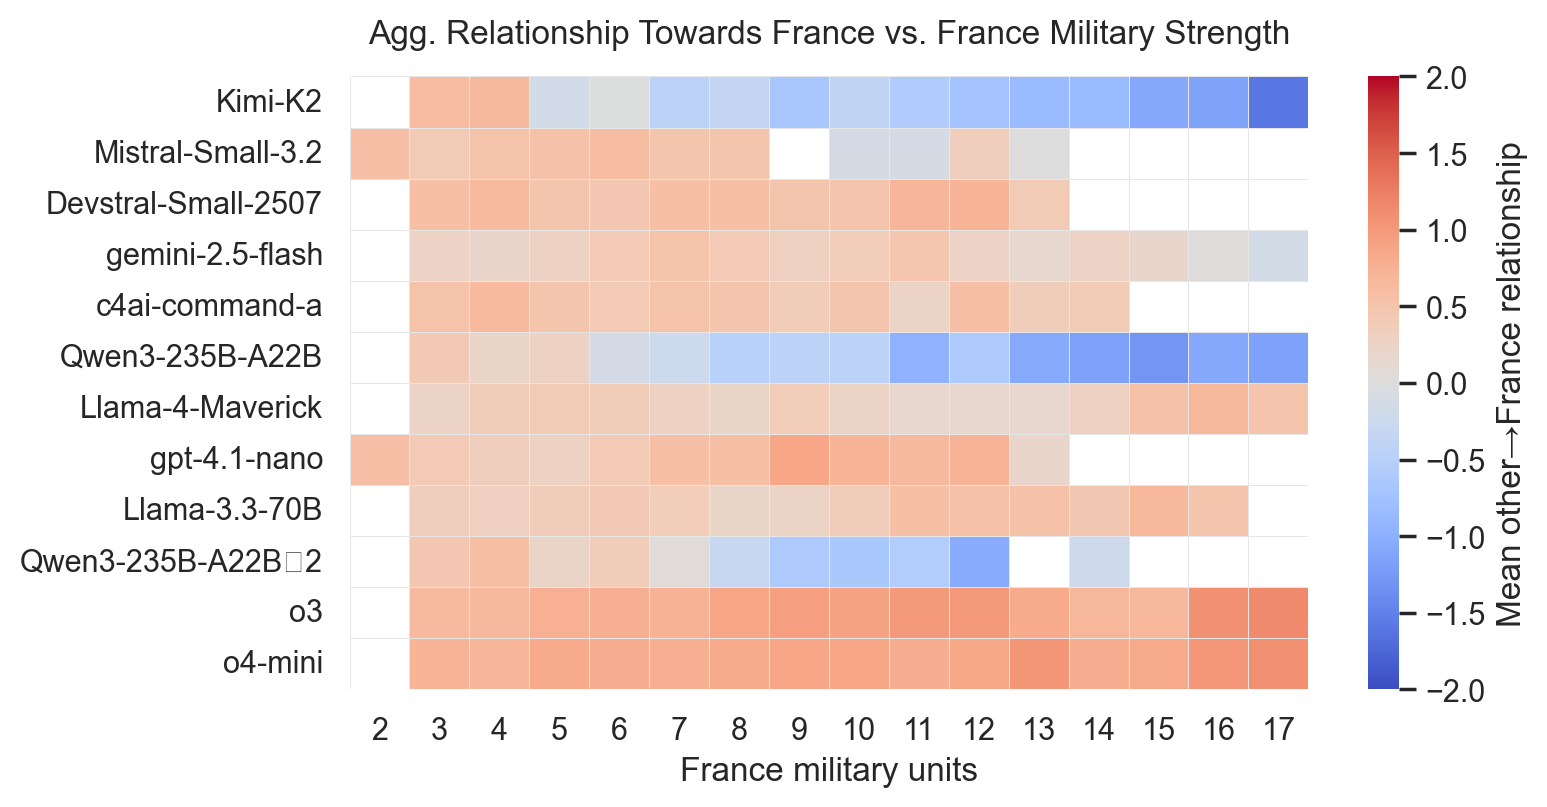

In [10]:
# %%
"""
Diplomatic credit vs. unit count
• Metric:  mean( other_power→France relationship score ) ⟂ France unit count
• One heat‑map cell = average across all phases of all runs in one benchmark dir

Notes
-----
* Relationships are parsed from strings like 'GERMANY:1|RUSSIA:-0.5|…'.
* Phases where France **or the other power** is eliminated are ignored.
* Sentiment columns are NOT used; everything comes from `relationships`.
"""

from pathlib import Path
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1.  Map benchmark directory → human‑readable model label  (edit as needed)
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "Kimi-K2",
    "../data/sam-exp081-bench": "Mistral-Small-3.2",
    "../data/sam-exp082-bench": "Devstral-Small-2507",
    "../data/sam-exp083-bench": "gemini-2.5-flash",
    "../data/sam-exp089-bench": "c4ai-command-a",
    "../data/sam-exp090-bench": "Qwen3-235B-A22B",
    "../data/sam-exp091-bench": "Llama-4-Maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "Llama-3.3-70B",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B‑2",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
}
model_order = list(exp_dirs.values())          # preserves the order above

# ---------------------------------------------------------------------------
# 2.  Helper to parse the `relationships` string
# ---------------------------------------------------------------------------
REL_PATTERN = re.compile(r'([A-Z]+):(-?\d+(?:\.\d+)?)')

def relationship_dict(rel_string: str) -> dict[str, float]:
    """'GERMANY:1|RUSSIA:-0.5' -> {'GERMANY': 1.0, 'RUSSIA': -0.5}"""
    if not isinstance(rel_string, str):
        return {}
    return {power: float(score) for power, score in REL_PATTERN.findall(rel_string)}

# ---------------------------------------------------------------------------
# 3.  Collect rows → (model, units, mean_other_to_france_score)
# ---------------------------------------------------------------------------
rows: list[dict] = []

for benchmark_dir, model_label in exp_dirs.items():
    csv_directory = (
        Path(benchmark_dir).expanduser().resolve()
        / "analysis/statistical_game_analysis/individual"
    )
    if not csv_directory.exists():
        print(f"[skip] {model_label}: directory not found")
        continue

    for csv_path in csv_directory.glob("run_*_phase_analysis.csv"):
        phase_df_full = pd.read_csv(csv_path)

        # keep only `order_generation` rows (matches earlier scripts)
        phase_df_full = phase_df_full[
            phase_df_full["analyzed_response_type"] == "order_generation"
        ]

        # group by game_phase for easier phase‑wise filtering
        for _, phase_df in phase_df_full.groupby("game_phase"):
            france_row = phase_df[phase_df["power_name"] == "FRANCE"]
            if france_row.empty:
                continue
            if france_row["supply_centers_owned_count"].iloc[0] == 0:
                continue                       # France eliminated this phase

            france_units = int(france_row["military_units_count"].iloc[0])

            # Collect other powers’ evaluations of France
            other_to_france_scores = []
            for _, player_row in phase_df.iterrows():
                if player_row["power_name"] == "FRANCE":
                    continue                   # skip France itself
                if player_row["supply_centers_owned_count"] == 0:
                    continue                   # other power eliminated

                rel_to_france = relationship_dict(
                    player_row["relationships"]
                ).get("FRANCE")

                if rel_to_france is not None:
                    other_to_france_scores.append(rel_to_france)

            if other_to_france_scores:
                rows.append({
                    "model": model_label,
                    "units": france_units,
                    "score": np.mean(other_to_france_scores),
                })

if not rows:
    raise RuntimeError("No data collected – check directory mapping or filters.")

raw_df = pd.DataFrame(rows)

# ---------------------------------------------------------------------------
# 4.  Aggregate → mean score per (model, units)
# ---------------------------------------------------------------------------
aggregated_df = (
    raw_df
    .groupby(["model", "units"], as_index=False)["score"]
    .mean()
)

# pivot to wide form for the heat‑map
heatmap_data = (
    aggregated_df
    .pivot(index="model", columns="units", values="score")
    .reindex(model_order)                 # models in user‑defined order
    .sort_index(axis=1)                   # unit counts ascending left→right
)

# ---------------------------------------------------------------------------
# 5.  Plot the heat‑map
# ---------------------------------------------------------------------------
sns.set_theme(style="white")
figure_width  = max(8, 0.45 * heatmap_data.shape[1])
figure_height = max(4, 0.35 * heatmap_data.shape[0])

plt.figure(figsize=(figure_width, figure_height), dpi=200)
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    vmin=-2, vmax=2,                  # relationship scale −2 … +2
    linewidths=0.3,
    linecolor="0.9",
    cbar_kws={"label": "Mean other→France relationship"},
)

ax.set_xlabel("France military units")
ax.set_ylabel("")                    # model labels act as y‑axis ticks
ax.set_title("Agg. Relationship Towards France vs. France Military Strength", pad=12)

plt.tight_layout()
plt.show()
# %%


/home/sam/.local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.draw()
/home/sam/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


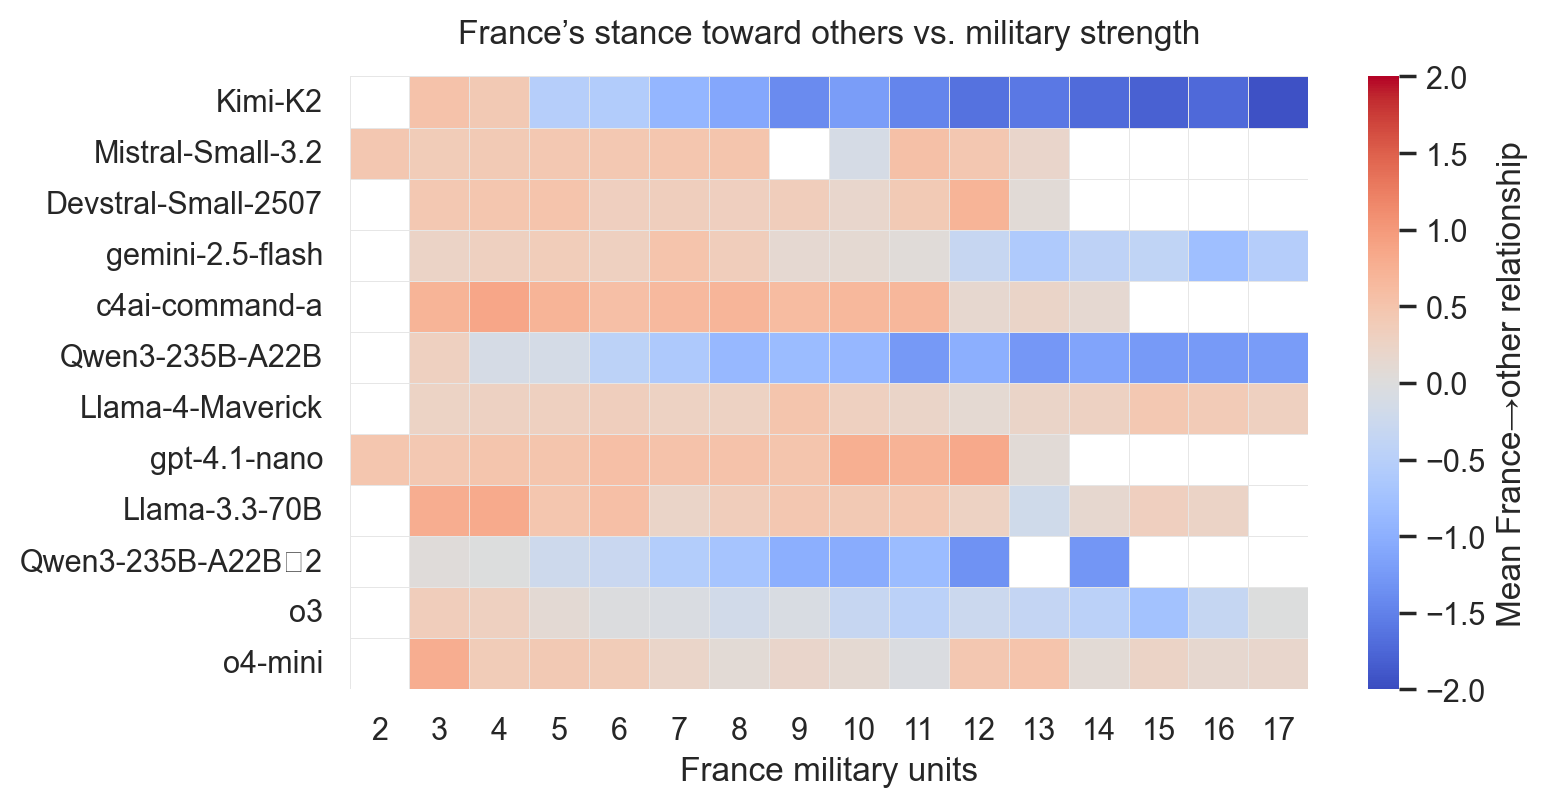

In [9]:
# %%
"""
Diplomatic credit vs. unit count  –  *France → others* direction
• Metric:  mean( France→other_power relationship score ) ⟂ France unit count
• One heat‑map cell = average across all phases of all runs in one benchmark dir

Notes
-----
* Relationships are parsed from strings like 'GERMANY:1|RUSSIA:-0.5|…'.
* A phase is ignored if France is eliminated.
* When averaging, only powers that are still alive in the phase and for which
  France specifies a relationship value are included.
"""

from pathlib import Path
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1.  Map benchmark directory → human‑readable model label  (edit as needed)
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "Kimi-K2",
    "../data/sam-exp081-bench": "Mistral-Small-3.2",
    "../data/sam-exp082-bench": "Devstral-Small-2507",
    "../data/sam-exp083-bench": "gemini-2.5-flash",
    "../data/sam-exp089-bench": "c4ai-command-a",
    "../data/sam-exp090-bench": "Qwen3-235B-A22B",
    "../data/sam-exp091-bench": "Llama-4-Maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "Llama-3.3-70B",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B‑2",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
}
model_order = list(exp_dirs.values())          # preserves the order above

# ---------------------------------------------------------------------------
# 2.  Helper to parse the `relationships` string
# ---------------------------------------------------------------------------
REL_PATTERN = re.compile(r'([A-Z]+):(-?\d+(?:\.\d+)?)')

def relationship_dict(rel_string: str) -> dict[str, float]:
    """'GERMANY:1|RUSSIA:-0.5' -> {'GERMANY': 1.0, 'RUSSIA': -0.5}"""
    if not isinstance(rel_string, str):
        return {}
    return {power: float(score) for power, score in REL_PATTERN.findall(rel_string)}

# ---------------------------------------------------------------------------
# 3.  Collect rows → (model, units, mean_france_to_other_score)
# ---------------------------------------------------------------------------
rows: list[dict] = []

for benchmark_dir, model_label in exp_dirs.items():
    csv_directory = (
        Path(benchmark_dir).expanduser().resolve()
        / "analysis/statistical_game_analysis/individual"
    )
    if not csv_directory.exists():
        print(f"[skip] {model_label}: directory not found")
        continue

    for csv_path in csv_directory.glob("run_*_phase_analysis.csv"):
        phase_df_full = pd.read_csv(csv_path)

        # Keep only `order_generation` rows
        phase_df_full = phase_df_full[
            phase_df_full["analyzed_response_type"] == "order_generation"
        ]

        # Iterate over each phase
        for _, phase_df in phase_df_full.groupby("game_phase"):
            france_row = phase_df[phase_df["power_name"] == "FRANCE"]
            if france_row.empty:
                continue
            if france_row["supply_centers_owned_count"].iloc[0] == 0:
                continue                       # France eliminated this phase

            france_units = int(france_row["military_units_count"].iloc[0])

            # France's relationship dictionary for this phase
            france_rel = relationship_dict(france_row["relationships"].iloc[0])

            france_to_other_scores = []
            for _, player_row in phase_df.iterrows():
                other_power = player_row["power_name"]
                if other_power == "FRANCE":
                    continue
                if player_row["supply_centers_owned_count"] == 0:
                    continue                   # other power eliminated

                rel_value = france_rel.get(other_power)
                if rel_value is not None:
                    france_to_other_scores.append(rel_value)

            if france_to_other_scores:
                rows.append({
                    "model": model_label,
                    "units": france_units,
                    "score": np.mean(france_to_other_scores),
                })

if not rows:
    raise RuntimeError("No data collected – check directory mapping or filters.")

raw_df = pd.DataFrame(rows)

# ---------------------------------------------------------------------------
# 4.  Aggregate → mean score per (model, units)
# ---------------------------------------------------------------------------
aggregated_df = (
    raw_df
    .groupby(["model", "units"], as_index=False)["score"]
    .mean()
)

# pivot to wide form for the heat‑map
heatmap_data = (
    aggregated_df
    .pivot(index="model", columns="units", values="score")
    .reindex(model_order)                 # models in predefined order
    .sort_index(axis=1)                   # unit counts ascending left→right
)

# ---------------------------------------------------------------------------
# 5.  Plot the heat‑map  (colour‑map = coolwarm, −2 … +2 scale)
# ---------------------------------------------------------------------------
sns.set_theme(style="white")
figure_width  = max(8, 0.45 * heatmap_data.shape[1])
figure_height = max(4, 0.35 * heatmap_data.shape[0])

plt.figure(figsize=(figure_width, figure_height), dpi=200)
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    vmin=-2, vmax=2,
    linewidths=0.3,
    linecolor="0.9",
    cbar_kws={"label": "Mean France→other relationship"},
)

ax.set_xlabel("France military units")
ax.set_ylabel("")                    # model labels serve as y‑axis ticks
ax.set_title("France’s stance toward others vs. military strength", pad=12)

plt.tight_layout()
plt.show()
# %%


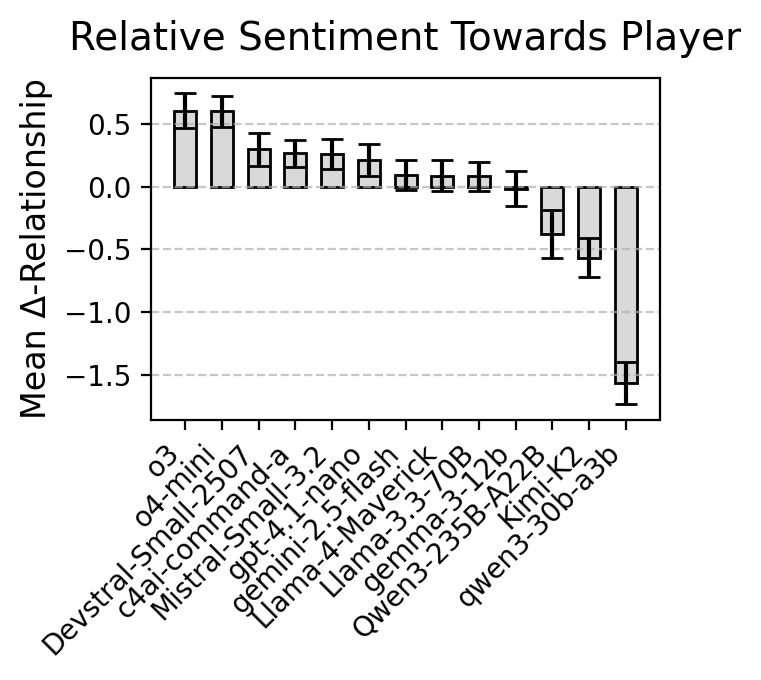

In [14]:
# ╔════════════════════════════════════════════════════════════════════════════╗
# ║  Relative “Other → France” Relationship (bar chart with 95 % CIs)         ║
# ║                                                                            ║
# ║  • For every run_*/phase_analysis CSV, compute the mean attitude of all    ║
# ║    surviving powers towards France in each phase.                          ║
# ║  • Bucket by France’s unit count.                                          ║
# ║  • For each unit bucket, subtract the *global* mean (across all models).   ║
# ║  • Average those differences across buckets → one relative score / run.    ║
# ║  • Aggregate per experiment dir → mean ± 95 % CI, then plot.               ║
# ╚════════════════════════════════════════════════════════════════════════════╝
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── 1.  Benchmark directories ────────────────────────────────────────────────
exp_dirs = {
    "../data/sam-exp080-bench": "Kimi-K2",
    "../data/sam-exp081-bench": "Mistral-Small-3.2",
    "../data/sam-exp082-bench": "Devstral-Small-2507",
    "../data/sam-exp083-bench": "gemini-2.5-flash",
    "../data/sam-exp089-bench": "c4ai-command-a",
    #"../data/sam-exp090-bench": "Qwen3-235B-A22B",
    "../data/sam-exp091-bench": "Llama-4-Maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp106-bench": "Llama-3.3-70B",
    "../data/sam-exp108-bench": "Qwen3-235B-A22B",
    "../data/sam-exp113-bench": "o3",
    "../data/sam-exp112-bench": "o4-mini",
    "../data/sam-exp118-bench": "gemma-3-12b",
    "../data/sam-exp119-bench": "qwen3-30b-a3b",
}
model_order = list(exp_dirs.values())

# ── 2.  Relationship-string parser ───────────────────────────────────────────
REL_PATTERN = re.compile(r'([A-Z]+):(-?\d+(?:\.\d+)?)')
def parse_relationships(s: str):
    if not isinstance(s, str):
        return {}
    return {p: float(v) for p, v in REL_PATTERN.findall(s)}

# ── 3.  Collect (run, model, unit_count, rel_score) rows ─────────────────────
rows = []
for bench_path, model_label in exp_dirs.items():
    phase_dir = (Path(bench_path).expanduser().resolve()
                 / "analysis/statistical_game_analysis/individual")
    if not phase_dir.exists():
        continue
    for csv_file in phase_dir.glob("run_*_phase_analysis.csv"):
        run_id = csv_file.stem.split("_")[1]  # crude but unique per file
        df = pd.read_csv(csv_file)
        df = df[df["analyzed_response_type"] == "order_generation"]

        for _, phase in df.groupby("game_phase"):
            fr = phase[phase["power_name"] == "FRANCE"]
            if fr.empty or fr["supply_centers_owned_count"].iat[0] == 0:
                continue  # France eliminated
            unit_cnt = int(fr["military_units_count"].iat[0])

            scores = []
            for _, row in phase.iterrows():
                if row["power_name"] == "FRANCE":
                    continue
                if row["supply_centers_owned_count"] == 0:
                    continue  # other power eliminated
                s = parse_relationships(row["relationships"]).get("FRANCE")
                if s is not None:
                    scores.append(s)

            if scores:
                rows.append({
                    "model": model_label,
                    "run": run_id,
                    "units": unit_cnt,
                    "score": np.mean(scores)
                })

if not rows:
    raise RuntimeError("No data found – check paths / filters.")

phase_df = pd.DataFrame(rows)

# ── 4.  Compute global baseline per unit bucket ─────────────────────────────
baseline = (
    phase_df
    .groupby("units", as_index=False)["score"]
    .mean()
    .rename(columns={"score": "baseline"})
)

phase_df = phase_df.merge(baseline, on="units")
phase_df["diff"] = phase_df["score"] - phase_df["baseline"]

# average diff across unit buckets → 1 score per run
run_scores = (
    phase_df
    .groupby(["model", "run"], as_index=False)["diff"]
    .mean()
    .rename(columns={"diff": "rel_score"})
)

# ── 5.  Aggregate per model (mean + 95 % CI) ────────────────────────────────
def ci95(series):
    n = series.size
    if n < 2:
        return 0.0
    return 1.96 * series.std(ddof=1) / np.sqrt(n)

summary = (
    run_scores
    .groupby("model")
    .agg(mean=("rel_score", "mean"), ci95=("rel_score", ci95))
    .reindex(model_order)
    .dropna()
    .sort_values("mean", ascending=False)
)

# ── 6.  Plot (style copied from earlier bar charts) ─────────────────────────
fig_w = max(7, 0.4 * len(summary)) * 0.5
fig_h = 7 * 0.5
plt.figure(figsize=(fig_w, fig_h), dpi=200)
ax = plt.gca()

x = np.arange(len(summary))
ax.bar(
    x,
    summary["mean"],
    width=0.6,
    yerr=summary["ci95"],
    capsize=4,
    color="0.85",
    edgecolor="black",
    linewidth=1.0,
)

ax.set_title("Relative Sentiment Towards Player", fontsize=14, pad=10)
ax.set_ylabel("Mean Δ-Relationship", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(summary.index, rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()